In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
df_test = pd.read_csv("../data/test.csv") # neobsahuje target
df = pd.read_parquet("../data/train_after_eda.parquet")
df = df.drop(columns="base_price")
df.head(3)

,id,week,center_id,meal_id,checkout_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,total_sale
0,1379560,1,55,1885,136.83,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,26955.33
1,1466964,1,55,1993,136.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0,36674.10
2,1346989,1,55,2539,134.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0,25677.54


In [6]:
CATEGORICAL_COLS = ["category", "cuisine", "center_type"]
for col in CATEGORICAL_COLS:
    encoder = OneHotEncoder()
    encoded_values = encoder.fit_transform(df[[col]])
    encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out([col]))
    df_encoded = pd.concat([df, encoded_df], axis=1)
    
OTHER_COLS = [col for col in df.columns if col not in CATEGORICAL_COLS]
df_encoded = df_encoded[OTHER_COLS]

In [7]:
PREDICTOR_COLUMS = [col for col in df_encoded.columns if col != "num_orders"]
train_df = df_encoded[df_encoded['week'] <= 120]
test_df = df_encoded[df_encoded['week'] >= 120]

X_train_enc = train_df[PREDICTOR_COLUMS]
y_train_enc = train_df[["num_orders"]]

X_test_enc = test_df[PREDICTOR_COLUMS]
y_test_enc = test_df[["num_orders"]]

In [8]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

rlm_model = sm.RLM(y_train_enc, sm.add_constant(X_train_enc)).fit()
y_pred = rlm_model.predict(sm.add_constant(X_test_enc))

r2, mae, mse = r2_score(y_test_enc, y_pred), mean_absolute_error(y_test_enc, y_pred), mean_squared_error(y_test_enc, y_pred)
print(f"R2: {r2} \t MAE: {mae} \t MSE: {mse}")

R2: 0.8700461903168095 	 MAE: 64.88020486839088 	 MSE: 17334.574954975717


In [9]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters like n_estimators
random_forest.fit(X_train_enc, y_train_enc)
y_pred = random_forest.predict(X_test_enc)

r2, mae, mse = r2_score(y_test_enc, y_pred), mean_absolute_error(y_test_enc, y_pred), mean_squared_error(y_test_enc, y_pred)
print(f"R2: {r2} \t MAE: {mae} \t MSE: {mse}")


/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_27017/128945246.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train_enc, y_train_enc)


R2: 0.9867441423026483 	 MAE: 14.002460924236926 	 MSE: 1768.202559104799


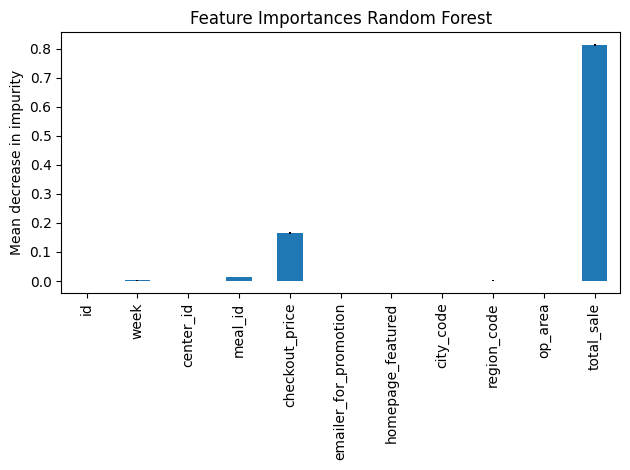

In [10]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_test_enc.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances Random Forest")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Results
1. Both models accomplished to reduce errors and increase R2Score significantly
2. I personally would use RobustRergession even though the scores are not the best for reasons I will mention in a bit

## Results
1. R2 scores very decent
2. MSE/MAE shrunk significantly

## Place for improvement
1. XGBoost/CatBoost instead of RandomForest
2. More variables such as lagging features
3. Combine more regressors
4. Delete features that do not contribute or maybe aggregate them (email/homepage) to one feature such as sentiment/loyalty

## Closing Thoughts
I could try out new methods and models and get better at forecasting. As far as my recommendation I would stick to robust regression for following reasons:
1. Good results
2. Fast to train (with more and more data as people buy groceries very often it will become lengthy and costly to train models and therefore I would prefer simple and fast, yet powerful method)
3. Scalability of RandomForest - In stores/meals etc. You will naturally want to evolve Your products/ try out new ones etc. Tree base models will not be able to predict for other than seen products and that will hinder progress/innovation of the store etc.. With a close to no performance loss You can have something that will still be very powerful to at least estimate some expectations about new/different/yet unseen product which will create space to for hypotheses and make smarter business decisions

I will try to implement app on top of this to improve my SWE skills. If anyone comes across this and would want to ask me anything or have any recommendations, critque I am more than happy to hear it since it will help me get better at what I do :) Thanks a lot and if You are reading this have a great day!